# [E3]Camera_Sticker

#카메라앱만들기 #동영상처리 #이미지검출 #추적 #카메라원근

# Step 1. 스티커 구하기 or 만들기

#### 디렉토리 구조 세팅하기
- camera_sticker/models
- camera_sticker/images 폴더 만든 후 
원하는 이미지와 스티커 넣기 완료!

In [1]:
# * 이미지 처리 관련 패키지 설치 완료!
# pip install opencv-python
# pip install cmake
# pip install dlib

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

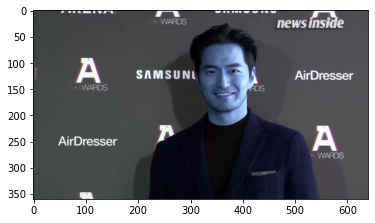

In [3]:
# 준비한 이미지 읽기 
import os
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/img3.jpg'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽기
img_bgr = cv2.resize(img_bgr, (640, 360))    # 640x360의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

In [4]:
# # 아래같은 오류가 뜨면 empty()부분에서 막힌거다. 즉 파일 경로에 사진이 없거나 파일 경로가 잘못된것!

# OpenCV(4.5.1) /tmp/pip-req-build-7m_g9lbm/opencv/modules/imgproc/src/resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

사진이 푸른 이유는!
* open cv는 이미지 채널을 BGR(파랑,녹색,빨강)을 사용하기 때문에!
* 하지만
*matplotilib, dlib 이미지 라이브러리는 채널을 RGB(빨,녹,파) 사용
* open cv에서 다룬 이미지를 다른 라이브러리에서 쓰려면 색갈보정 필요!

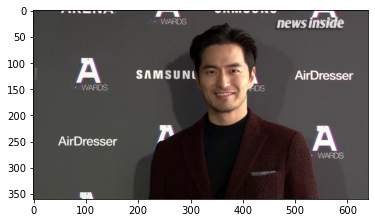

In [5]:
img_rgb = cv2.cvtColor(img_bgr,cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

# Step 2. 얼굴 검출 & 랜드마크 검출 하기

* dlib의 face detector은 HOG를 사용해서 SVM의 sliding window로 얼굴을 찾는다. - 설명 보충할것 

In [6]:
import dlib # detector 선언
detector_hog = dlib.get_frontal_face_detector()
print()

In [7]:
#detector로 얼굴의 bounding box 추출
#dlib은 rgb이미지를 받기 때문에 cvtColor()로 opencv 이미지를 rgb로 바꿔준다.
img_rgb = cv2.cvtColor(img_bgr,cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb,1) 

#[1]은 이미지 파라미드값이다. 
# 이미지 크기를 키워서 얼굴을 검출하면 더 정확한 검출 가능!

rectangles[[(306, 80) (414, 187)]]


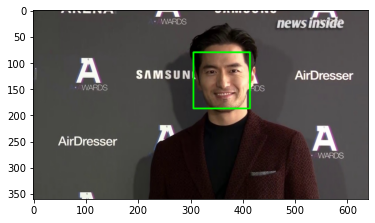

In [8]:
# 찾은 얼굴 출력

print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

# Step 3. 스티커 적용 위치 확인하기

* 스티커를 적용하기 위해서는 이목구비 위치를 아는게 중요하다!
* 이목구비를 찾을땐 face landmark localization기술을 사용한다.
* 객체 내부의 점을 찾는 기술이다. 
* 방법은 크게 2가지로 나눠진다. 
1. top-down : bounding box를 찾고 박스 내부의 keypoint를 에측
2. bottom-up: 이미지 전체의 keypoint찾고 point관계를 이용해 군집화해서 box 생성

### 3-1) landmark localization 기술 
* 얼굴에서 이목구비 찾기! = 랜드마크 찾기

In [9]:
# 터미널에서 dlib의 제공되는 모델 다운로드하기!
# wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
# mv shape_predictor_68_face_landmarks.dat.bz2 ~/aiffel/camera_sticker/models
# cd ~/aiffel/camera_sticker && bzip2 -d ./models/shape_predictor_68_face_landmarks.dat.bz2

In [10]:
# landmark 모델 불러오기
import os
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)
print("🌫🛸")

🌫🛸


In [11]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect) # rgb 이미지 반환
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

#point는 dlib.full_object_detection의 객체라서 part()함수로 개별접근 가능하다
#더 보기 쉽게 x,y 형태로 변환함
# list_point는 (x,y) 68개로 이뤄진 list다. 즉, 이미지에 랜드마크가 68개다.

68


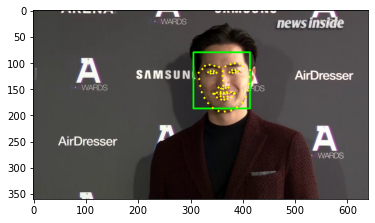

In [12]:
for landmark in list_landmarks:
    for idx,point in enumerate(list_points):
        cv2.circle(img_show,point,2,(0,255,255),-1)
img_show_rgb = cv2.cvtColor(img_show,cv2.COLOR_BGR2RGB)

plt.imshow(img_show_rgb)
plt.show()

# Step 4. 스티커 적용하기

In [13]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[33]) # 코의 좌표값
    x = landmark[33][0] # 수염의 중앙 좌표값
    y = landmark[33][1] # 수염의 중앙 좌표값
    w = dlib_rect.width() #스티커 크기
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(363, 150)
(x,y) : (363,150)
(w,h) : (109,109)


(109, 109, 3)


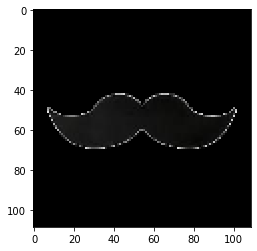

In [14]:
import os
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/mustach-11.png'
img_sticker=cv2.imread(sticker_path)
img_sticker=cv2.resize(img_sticker,(w,h))
print(img_sticker.shape)
plt.imshow(cv2.cvtColor(img_sticker, cv2.COLOR_BGR2RGB))
plt.show()

In [15]:
# 원본에 스티커 이미지 추가하기
# 스티커에 점을 2개를 둬서 위치를 조정하기 
refined_x=x-w//2 #스티커 좌측 상단 좌표값(!)
refined_y=y-h//2
refined_x1=x+w//2 #우측 하단 좌표값
refined_y1=y+h//2
print('(x,y):(%d,%d)'%(refined_x,refined_y))
print('(x,y):(%d,%d)'%(refined_x1,refined_y1))

(x,y):(309,96)
(x,y):(417,204)


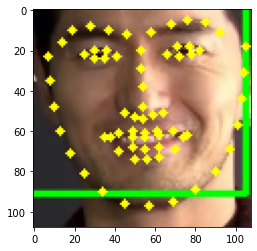

In [16]:
#스티커가 아래로 안내려 와서 sticker_area를 확인하는 작업을 반복했다.
# 이미지 show에서 스티커의 영역을 지정한다. [:]는 범위를 어디서부터 어디까지인지 범위 지정

sticker_area = img_show[refined_y:refined_y1,refined_x:refined_x1]
plt.imshow(cv2.cvtColor(sticker_area, cv2.COLOR_BGR2RGB))
plt.show()

In [17]:
#사이즈가 맞지 않아서 오류가 떴다.
print(sticker_area.shape)

(108, 108, 3)


In [18]:
#이미지 스티커 사이즈를 다시 맞춰줬다.
img_sticker=cv2.resize(img_sticker,(sticker_area.shape[1], sticker_area.shape[0]))
print(img_sticker.shape)

(108, 108, 3)


In [19]:
img_show[refined_y:refined_y1,refined_x:refined_x1]=\
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)

코드를 한줄씩 뜯어보자
* sticker_area = img_show[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]

1.sticker_area는 원본이미지에서 스티커 자리를 정하고 변수 선언

2.원본이미지에 스티커를 합칠때 스티커를 위에 붙이는게 아니라 원본의 색을 바꿔준거다. 
* 예를 들면, 원래 스티커 전체 면적에 있는 0.0=빨강, 0.1=검정 인 픽셀값을 
* 원본에 스티커 놓을 곳의 색을 바꿔서 스티커를 놓은것 처럼 표현한다.
* 2번째 줄 함수에서 픽셀값을 바꾸는 작업을 함

3.1번에서 스티커 자리 만든 후 조건을 주며 픽셀값을 조절
* np.where은 조건문으로 해석하면 
* 스티커값이 0(투명하다는 의미)이면 원본이미지색을 표현한다. 아니면 스티커 색을 표현한다.
* 이때 0값을 조건에 넣지 않으면(=투명한 부분을 어떻게 처리할지 말하지 않으면) 검정색으로 표현함 - 왜인지는 모르겠지만, 컴퓨터 색의 기본값이 검정이라서 그런거 같음 

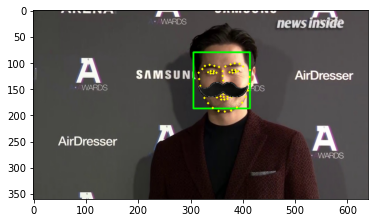

In [20]:
plt.imshow(cv2.cvtColor(img_show,cv2.COLOR_BGR2RGB))
plt.show()

드디어...나왔다...ㅎ

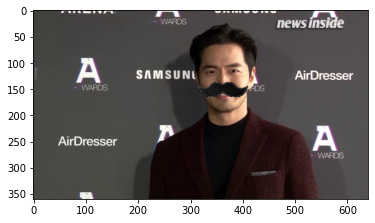

In [21]:
sticker_area = img_bgr[refined_y:refined_y1,refined_x:refined_x1]
img_bgr[refined_y:refined_y1,refined_x:refined_x1]=\
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

# 루브릭 평가

1. 자기만의 카메라앱 기능 구현을 완수하였다.
- 합성은 됐다...
- 스티커를 투명배경,png로 받아도 배경이 사라지지 않아서 흰색배경을 다운 받은 후 배경을 없애는 방식 사용했다. 

2. 스티커 이미지를 정확한 원본 위치에 반영하였다
- 이 과정이 너무 오래 걸렸다...코드는 맞는거 같은데 스티커가 머리에서 내려오지 않았다. 

- 노드에서 사용하는 방식이 아닌 스티커에 좌측 위와 우측 아래에 점을 두개 찍어서 가져오는 방식으로 위치를 조정했다. 

# 회고

- 스티커가 머리에서 내려오지 않아서 포기할까 고민한 프로젝트...
- 코드는 맞는거 같은데 뭐가 틀린지 몰라서 한참을 헤맸다..
- 처음에는 원리는 정확히 파악하지 못하고 흐름만 대충 이해하고 랜드마크를 수정했다.
- 오류가 날수록 코드를 더 정확히 이해하고 꼼꼼하게 보게 됐다. 
- 좌표를 이해하는 과정이 어려웠는데 좌표를 정확하게 이해하게 됐다. 
- 이미지의 구도가 바뀌면 어떻게 달라질지도 궁금하지만 다음에 도전해보려고 한다...